In [39]:
import keras
from keras.utils import np_utils
from keras.datasets import mnist
import numpy as np
import os
import sys
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, Conv2D, BatchNormalization
from keras.models import save_model, load_model
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Model
from collections import OrderedDict

print("Keras version: {}".format(keras.__version__))

Keras version: 2.1.6


In [2]:
!python --version

Python 3.5.4 :: Anaconda custom (64-bit)


# Data Preparation

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path=os.path.join('.','keras_mnist'))

In [4]:
type(x_train)

numpy.ndarray

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [7]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

# Model

In [8]:
batch_size = 128
nb_classes = 10
nb_epoch = 1

img_rows, img_cols = 28, 28
pool_size = (2,2)
kernel_size = (3,3)

In [9]:
# (sample_num, row, col, channel)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

# one-hot encoding
# e.g. array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [10]:
model = Sequential()

# first convolutional layer
model.add(Conv2D(32, (kernel_size[0], kernel_size[1]), padding='valid', input_shape=input_shape))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))

# second convolutional layer
model.add(Conv2D(32, (kernel_size[0], kernel_size[1])))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))

# max pooling layer
model.add(MaxPooling2D(pool_size=pool_size))

# flatten
model.add(Flatten())

# First Dense layer (FC 1)
model.add(Dense(128))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))

# Second Dense Layer (FC 2)
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
__________

# Learning

## Default loss

In [12]:
# define loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

## Custom loss

In [93]:
def np_expert_loss(y_true, y_pred):
    """
    y_true: [batch_size, nb_classes]
    y_pred: [batch_size, nb_classes]
    """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, y_true.size)
        y_pred = y_pred.reshape(1, y_pred.size)
        
    if y_true.size == y_pred.size:
        y_true_idx = y_true.argmax(axis=1)
    
    batch_size = y_true.shape[0]
    return -np.sum(np.log(y_pred[np.arange(batch_size), y_true_idx] + 1e-7)) / batch_size

In [20]:
def default_expert_loss(y_true, y_pred):
    """
    (Tensor, not numpy array) y_true: [batch_size, nb_classes]
    (Tensor, not numpy array) y_pred: [batch_size, nb_classes]
    """
    
    y_res = keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return y_res

In [92]:
def mean_squared_error(y_true, y_pred):
    y_res = K.mean(K.square(y_pred - y_true), axis=-1)
    print(K.shape(y_res))
    return y_res

In [18]:
def expert_loss(y_true, y_pred):
    """
    (Tensor, not numpy array) y_true: [batch_size, nb_classes]
    (Tensor, not numpy array) y_pred: [batch_size, nb_classes]
    """
    if K.ndim(y_true) == 1:
        y_true = K.reshape(y_true, [1, K.shape(y_true)[0]], dtype="float32")
        y_pred = K.reshape(y_pred, [1, K.shape(y_pred)[0]], dtype="float32")
    
    b_size = K.cast(K.shape(y_pred)[0], dtype="float32")
    y_res = -K.sum(y_true * K.log(y_pred + 1e-7)) / b_size   # return 
    return y_res

In [12]:
def correct_ratio(y_true, y_pred):
    """
    return: (1) can be a tensor list, (2) can be a tensor scalar
    """
    true_list = K.argmax(y_true)
    pred_list = K.argmax(y_pred)
    correct = K.cast(K.equal(true_list, pred_list), "float32")
    mean_correct = K.mean(correct)
    return mean_correct

In [12]:
#model.compile(loss=expert_loss, optimizer='adadelta', metrics=['acc', correct_ratio])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'], weighted_metrics=['accuracy'])

In [12]:
modelpath = os.path.join('.','keras_model','mlp.h5')

In [13]:
# load the model if it exists
if os.path.isfile(modelpath):
    model = load_model(modelpath)

# Training

In [15]:
tbCallBack = keras.callbacks.TensorBoard(log_dir=os.path.join('.','keras_model','graph'), \
                                         histogram_freq=0, \
                                         write_graph=True, \
                                         write_images=True)

In [16]:
# training the model
model.fit(x_train, y_train, \
          batch_size=batch_size, \
          epochs=nb_epoch, \
          verbose=1, \
          validation_data=(x_test, y_test), \
          shuffle=True, \
         callbacks=[tbCallBack])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 249s 4ms/step - loss: 0.1069 - acc: 0.9713 - weighted_acc: 0.9713 - val_loss: 0.0537 - val_acc: 0.9831 - val_weighted_acc: 0.9831


# Evaluating

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: {}.'.format(score[0]))
print('Test Accuracy: {}.'.format(score[1]))

Test Score: 0.05368674308508634.
Test Accuracy: 0.9831.


# Inference

In [14]:
pred = model.predict(x_test[0:2])
print(np.argmax(pred, axis=1))

[7 2]


# Export

In [18]:
save_model(model, modelpath)

# Advanced: Specific Layer Output

In [17]:
inp = model.input                                           # input placeholder
print(inp)

Tensor("conv2d_1_input_1:0", shape=(?, 28, 28, 1), dtype=float32)


In [84]:
outputs = [layer.output for layer in model.layers]          # all layer outputs

for out in range(len(outputs)): 
    print(out, ":", outputs[out])

0 : Tensor("conv2d_1_1/BiasAdd:0", shape=(?, 26, 26, 32), dtype=float32)
1 : Tensor("batch_normalization_1_1/cond/Merge:0", shape=(?, 26, 26, 32), dtype=float32)
2 : Tensor("activation_1_1/Relu:0", shape=(?, 26, 26, 32), dtype=float32)
3 : Tensor("conv2d_2_1/BiasAdd:0", shape=(?, 24, 24, 32), dtype=float32)
4 : Tensor("batch_normalization_2_1/cond/Merge:0", shape=(?, 24, 24, 32), dtype=float32)
5 : Tensor("activation_2_1/Relu:0", shape=(?, 24, 24, 32), dtype=float32)
6 : Tensor("max_pooling2d_1_1/MaxPool:0", shape=(?, 12, 12, 32), dtype=float32)
7 : Tensor("flatten_1_1/Reshape:0", shape=(?, ?), dtype=float32)
8 : Tensor("dense_1_1/BiasAdd:0", shape=(?, 128), dtype=float32)
9 : Tensor("batch_normalization_3_1/cond/Merge:0", shape=(?, 128), dtype=float32)
10 : Tensor("activation_3_1/Relu:0", shape=(?, 128), dtype=float32)
11 : Tensor("dense_2_1/BiasAdd:0", shape=(?, 10), dtype=float32)
12 : Tensor("activation_4_1/Softmax:0", shape=(?, 10), dtype=float32)


In [70]:
# inp: the placeholder image
# outputs[-1]: the latest layer
functons = K.function([inp], [outputs[-1]])

In [71]:
keras_partial_res, = functons([x_test[0].reshape(1, 28, 28, 1)])

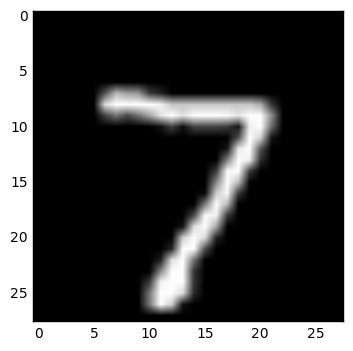

In [72]:
test_img = np.minimum(x_test[0] * 255., 255.).reshape((28,28))  # reshape to (28, 28) for plt.imshow()
test_img = test_img.astype("uint8")
plt.imshow(test_img, cmap='gray')
plt.show()

In [73]:
np.argmax(keras_partial_res)

7

# Layer Editing

## Origin Layer

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
__________

## Layer Insertion

In [21]:
def show_layer(edit_model):
    layers = [l for l in edit_model.layers]
    for l in range(len(layers)): 
        print(l, ":", layers[l].input, "->", layers[l].output)

In [22]:
show_layer(model)

0 : Tensor("conv2d_1_input_1:0", shape=(?, 28, 28, 1), dtype=float32) -> Tensor("conv2d_1_1/BiasAdd:0", shape=(?, 26, 26, 32), dtype=float32)
1 : Tensor("conv2d_1_1/BiasAdd:0", shape=(?, 26, 26, 32), dtype=float32) -> Tensor("batch_normalization_1_1/cond/Merge:0", shape=(?, 26, 26, 32), dtype=float32)
2 : Tensor("batch_normalization_1_1/cond/Merge:0", shape=(?, 26, 26, 32), dtype=float32) -> Tensor("activation_1_1/Relu:0", shape=(?, 26, 26, 32), dtype=float32)
3 : Tensor("activation_1_1/Relu:0", shape=(?, 26, 26, 32), dtype=float32) -> Tensor("conv2d_2_1/BiasAdd:0", shape=(?, 24, 24, 32), dtype=float32)
4 : Tensor("conv2d_2_1/BiasAdd:0", shape=(?, 24, 24, 32), dtype=float32) -> Tensor("batch_normalization_2_1/cond/Merge:0", shape=(?, 24, 24, 32), dtype=float32)
5 : Tensor("batch_normalization_2_1/cond/Merge:0", shape=(?, 24, 24, 32), dtype=float32) -> Tensor("activation_2_1/Relu:0", shape=(?, 24, 24, 32), dtype=float32)
6 : Tensor("activation_2_1/Relu:0", shape=(?, 24, 24, 32), dtype=f

In [28]:
def insert_layer(edit_model, layer_id, new_layer):
    """
    layer_id: start from input with 0
    """
    layers = [l for l in edit_model.layers]
    
    #for l in layers: print(l.input, l.output)
    
    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            for layer_idx in new_layer:
                x = layer_idx(x)
        x = layers[i](x)
        
    new_model = Model(input=layers[0].input, outputs=x)
    
    return new_model

In [35]:
inserted_model = insert_layer(model, 11, [Dense(128), BatchNormalization(), Activation('relu')])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("co...)`


In [36]:
inserted_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
__________

## Replace Layer

In [38]:
def replace_intermediate_single_layer_in_keras(edit_model, layer_id, new_layer):
    layers = [l for l in edit_model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        else:
            x = layers[i](x)

    new_model = Model(input=layers[0].input, output=x)
    return new_model

In [40]:
def replace_intermediate_multiple_layer_in_keras(edit_model, layer_dict):
    layers = [l for l in edit_model.layers]
    
    layer_id = list(layer_dict.keys())

    x = layers[0].output
    for i in range(1, len(layers)):
        if i in layer_id:
            x = layer_dict[i](x)
        else:
            x = layers[i](x)

    new_model = Model(input=layers[0].input, output=x)
    return new_model

In [42]:
replaced_layer = OrderedDict()
replaced_layer[11] = Dense(2)
replaced_layer[12] = Activation('softmax')
replaced_model = replace_intermediate_multiple_layer_in_keras(model, replaced_layer)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("co...)`


In [43]:
replaced_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
__________

# Export from .h5 to .tflite

In [21]:
!pip install tf-nightly

    100% |################################| 90.9MB 175kB/s ta 0:00:011 2% |                                | 2.6MB 2.0MB/s eta 0:00:46    3% |                                | 2.7MB 2.5MB/s eta 0:00:36    3% |#                               | 3.2MB 4.7MB/s eta 0:00:19    4% |#                               | 3.9MB 1.7MB/s eta 0:00:50    11% |###                             | 10.1MB 5.1MB/s eta 0:00:16    11% |###                             | 10.5MB 9.5MB/s eta 0:00:09    21% |#######                         | 20.0MB 5.5MB/s eta 0:00:13    23% |#######                         | 21.2MB 7.4MB/s eta 0:00:10    23% |#######                         | 21.4MB 4.3MB/s eta 0:00:17    24% |#######                         | 22.5MB 1.6MB/s eta 0:00:43    26% |########                        | 24.0MB 7.3MB/s eta 0:00:10    26% |########                        | 24.4MB 3.7MB/s eta 0:00:18    27% |########                        | 25.1MB 4.8MB/s eta 0:00:14    29% |#########                       | 2

In [22]:
import tensorflow as tf

print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.13.0-dev20181120


In [20]:
tflite_path = os.path.join('.','keras_model','mlp.tflite')
assert os.path.exists(modelpath), ".h5 file is not found."

In [23]:
converter = tf.contrib.lite.TocoConverter.from_keras_model_file(modelpath)
tflite_model = converter.convert()
open(tflite_path, "wb").write(tflite_model)

Instructions for updating:
Use `lite.TFLiteConverter.from_keras_model_file` instead.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 20 variables.
INFO:tensorflow:Converted 20 variables to const ops.


2405224